# load in packages and data

In [9]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.utils.random import sample_without_replacement

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

In [2]:
# take in .root into arrays
arrays = (uproot.open("TTbar_PU200_D49_prompt.root")["L1TrackNtuple/eventTree"]
                .arrays("*", namedecode="utf-8"))

In [3]:
# a look at what variables you can use as inputs to your model
arrays.keys()

dict_keys(['trk_pt', 'trk_eta', 'trk_phi', 'trk_d0', 'trk_z0', 'trk_chi2', 'trk_chi2rphi', 'trk_chi2rz', 'trk_bendchi2', 'trk_nstub', 'trk_lhits', 'trk_dhits', 'trk_seed', 'trk_hitpattern', 'trk_phiSector', 'trk_genuine', 'trk_loose', 'trk_unknown', 'trk_combinatoric', 'trk_fake', 'trk_matchtp_pdgid', 'trk_matchtp_pt', 'trk_matchtp_eta', 'trk_matchtp_phi', 'trk_matchtp_z0', 'trk_matchtp_dxy', 'tp_pt', 'tp_eta', 'tp_phi', 'tp_dxy', 'tp_d0', 'tp_z0', 'tp_d0_prod', 'tp_z0_prod', 'tp_pdgid', 'tp_nmatch', 'tp_nstub', 'tp_eventid', 'tp_charge', 'matchtrk_pt', 'matchtrk_eta', 'matchtrk_phi', 'matchtrk_z0', 'matchtrk_d0', 'matchtrk_chi2', 'matchtrk_chi2rphi', 'matchtrk_chi2rz', 'matchtrk_bendchi2', 'matchtrk_nstub', 'matchtrk_lhits', 'matchtrk_dhits', 'matchtrk_seed', 'matchtrk_hitpattern'])

# create train and test samples

In [33]:
# select features from data and put in proper format
# 'trk_fake' is the track quality variable, truth data

features = ['trk_pt','trk_eta','trk_phi','trk_z0','trk_chi2rphi','trk_chi2rz','trk_bendchi2','trk_bendchi2']
X = np.empty((len(arrays[features[0]].flatten()),len(features)))
for i in range(len(features)):
    X[:,i] = arrays[features[i]].flatten()

y = arrays['trk_fake'].flatten()
y[y==2] = 1

# grab pdgid for certain studies
pdgid = arrays['trk_matchtp_pdgid'].flatten()

In [34]:
# get rid of any nan instances
find_nan = np.argwhere(np.isnan(X))
X = np.delete(X, find_nan[:,0], 0)
y = np.delete(y, find_nan[:,0])
pdgid = np.delete(pdgid, find_nan[:,0])

In [37]:
#create train and test sets with 2500 of each mu, elec, had, fake in train, rest in test

mu_idx = sample_without_replacement(len(X[abs(pdgid)==13]),2500,random_state=23)
elec_idx = sample_without_replacement(len(X[abs(pdgid)==11]),2500,random_state=23)
had_idx = sample_without_replacement(len(X[np.logical_and(abs(pdgid)>37,pdgid!=-999)]),2500,random_state=23)
fake_idx = sample_without_replacement(len(X[pdgid==-999]),2500,random_state=23)

X_train = np.concatenate((X[abs(pdgid)==13][mu_idx],X[abs(pdgid)==11][elec_idx],X[np.logical_and(abs(pdgid)>37,pdgid!=-999)][had_idx],X[pdgid==-999][fake_idx]))
y_train = np.concatenate((y[abs(pdgid)==13][mu_idx],y[abs(pdgid)==11][elec_idx],y[np.logical_and(abs(pdgid)>37,pdgid!=-999)][had_idx],y[pdgid==-999][fake_idx]))
pdgid_train = np.concatenate((pdgid[abs(pdgid)==13][mu_idx],pdgid[abs(pdgid)==11][elec_idx],pdgid[np.logical_and(abs(pdgid)>37,pdgid!=-999)][had_idx],pdgid[pdgid==-999][fake_idx]))

X_test = np.concatenate((np.delete(X[abs(pdgid)==13],mu_idx,axis=0),np.delete(X[abs(pdgid)==11],elec_idx,axis=0),np.delete(X[np.logical_and(abs(pdgid)>37,pdgid!=-999)],had_idx,axis=0),np.delete(X[pdgid==-999],fake_idx,axis=0)))
y_test = np.concatenate((np.delete(y[abs(pdgid)==13],mu_idx,axis=0),np.delete(y[abs(pdgid)==11],elec_idx,axis=0),np.delete(y[np.logical_and(abs(pdgid)>37,pdgid!=-999)],had_idx,axis=0),np.delete(y[pdgid==-999],fake_idx,axis=0)))
pdgid_test = np.concatenate((np.delete(pdgid[abs(pdgid)==13],mu_idx,axis=0),np.delete(pdgid[abs(pdgid)==11],elec_idx,axis=0),np.delete(pdgid[np.logical_and(abs(pdgid)>37,pdgid!=-999)],had_idx,axis=0),np.delete(pdgid[pdgid==-999],fake_idx,axis=0)))

X_train,y_train,pdgid_train = shuffle(X_train,y_train,pdgid_train,random_state=23)
X_test,y_test,pdgid_test = shuffle(X_test,y_test,pdgid_test,random_state=23)

# train NN

In [ ]:
clear_session()

In [40]:
clf_NN = Sequential()
clf_NN.add(Dense(128, input_dim=len(features), activation='relu')) # each Dense layer is a fully-connected layer in the NN being added
clf_NN.add(Dense(64, activation='relu'))
clf_NN.add(Dense(1, activation='sigmoid'))
clf_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
clf_NN.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0) #verbose is supressing output

# check NN performance

In [74]:
# create roc curve
y_pred = clf_NN.predict(X_test)[:,0]
fpr, tpr, dt = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test, y_pred)

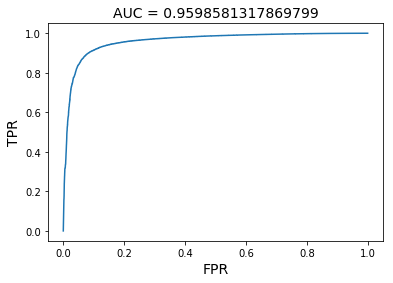

In [75]:
plt.plot(fpr,tpr)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.title('AUC = '+str(auc),fontsize=14)
plt.show()

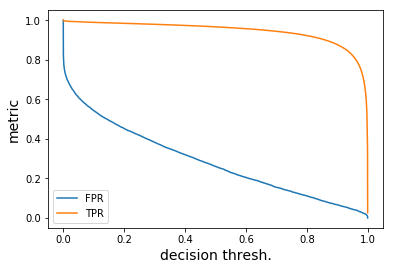

In [79]:
plt.plot(dt[1:],fpr[1:],label='FPR')
plt.plot(dt[1:],tpr[1:],label='TPR')
plt.xlabel('decision thresh.',fontsize=14)
plt.ylabel('metric',fontsize=14)
plt.legend(loc='best')
plt.show()

In [84]:
def get_eff_faker_err(y_pred, y_true):

    # efficiency = (# reals labeled real)/(# reals) <-this is really TPR
    TP = (y_pred[y_true==1]==1).sum()
    reals = len(y_true[y_true==1])
    eff = TP/reals
    err_eff = np.sqrt(TP*(reals-TP)/reals**3)

    if y_true.all()==1:
        return eff, 0, err_eff, 0
    
    # fake rate = (# fakes labeled real)/(#fakes) <-this is really FPR
    FP = (y_pred[y_true==0]==1).sum()
    fakes = len(y_true[y_true==0])
    faker = FP/fakes
    err_faker = np.sqrt(FP*(fakes-FP)/fakes**3)
    
    return eff, faker, err_eff, err_faker

In [104]:
#create eff (tpr) vs pt
dt = .5 #set decision threshold
pt_bins = np.logspace(.3,2,12) #2 to 100 GeV in 12 bins
tpr_pt = []
tpr_pt_err = []
fpr_pt = []
fpr_pt_err = []
for i in range(len(pt_bins)):
    idx_temp = np.digitize(X_test[:,0],pt_bins,right=True)==i #trk_pt is 0th column in X
    X_temp = X_test[idx_temp]
    y_temp = y_test[idx_temp]
    
    if (len(y_temp)==0):
        tpr_pt.append(0)
        tpr_pt_err.append(0)
        fpr_pt.append(0)
        fpr_pt_err.append(0)
        continue
        
    y_pred = (clf_NN.predict(X_temp)[:,0]>dt)*1
    tpr, fpr, tpr_err, fpr_err = get_eff_faker_err(y_pred,y_temp)
    
    tpr_pt.append(tpr)
    tpr_pt_err.append(tpr_err)
    fpr_pt.append(fpr)
    fpr_pt_err.append(fpr_err)

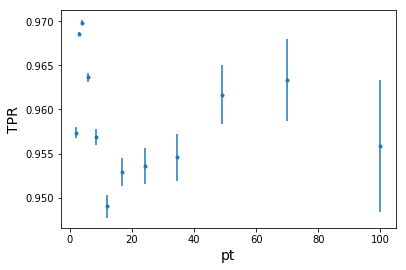

In [105]:
plt.errorbar(pt_bins,tpr_pt,yerr=tpr_pt_err,linestyle='None',fmt='.')
plt.xlabel('pt',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

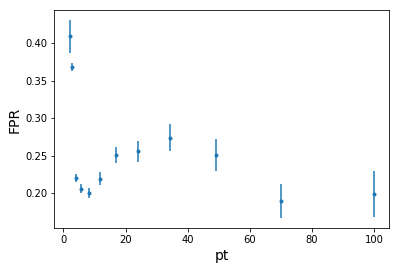

In [106]:
plt.errorbar(pt_bins,fpr_pt,yerr=fpr_pt_err,linestyle='None',fmt='.')
plt.xlabel('pt',fontsize=14)
plt.ylabel('FPR',fontsize=14)
plt.show()

In [107]:
#create eff (tpr) vs eta
dt = .5
eta_bins = np.linspace(-2.4,2.4,20)
tpr_eta = []
tpr_eta_err = []
fpr_eta = []
fpr_eta_err = []
for i in range(len(eta_bins)):
    idx_temp = np.digitize(X_test[:,1],eta_bins,right=True)==i #trk_eta is 1st column in X
    X_temp = X_test[idx_temp]
    y_temp = y_test[idx_temp]
    
    if (len(y_temp)==0):
        tpr_eta.append(0)
        tpr_eta_err.append(0)
        fpr_eta.append(0)
        fpr_eta_err.append(0)
        continue
        
    y_pred = (clf_NN.predict(X_temp)[:,0]>dt)*1
    tpr, fpr, tpr_err, fpr_err = get_eff_faker_err(y_pred,y_temp)
    
    tpr_eta.append(tpr)
    tpr_eta_err.append(tpr_err)
    fpr_eta.append(fpr)
    fpr_eta_err.append(fpr_err)

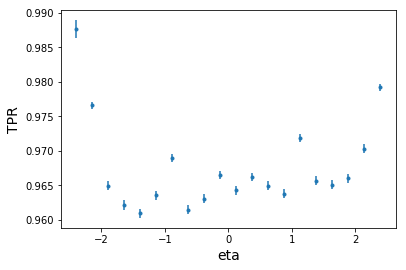

In [108]:
plt.errorbar(eta_bins,tpr_eta,yerr=tpr_eta_err,linestyle='None',fmt='.')
plt.xlabel('eta',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

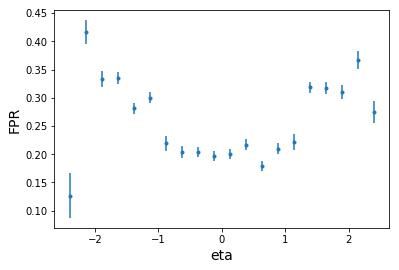

In [109]:
plt.errorbar(eta_bins,fpr_eta,yerr=fpr_eta_err,linestyle='None',fmt='.')
plt.xlabel('eta',fontsize=14)
plt.ylabel('FPR',fontsize=14)
plt.show()